## Import libraries

In [35]:
!pip install imutils

In [36]:
import os
import cv2
import numpy as np
import random
import keras

from imutils import paths
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.efficientnet import EfficientNetB3#EfficientNetV2B3
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization,MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score

from sklearn.metrics import plot_confusion_matrix
import matplotlib.patches as mpatches
import pandas as pd

## sample inage

### With Mask

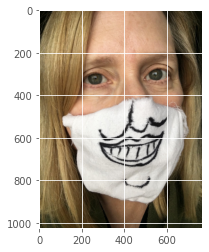

In [37]:
images_withMask = os.listdir("./New Masks Dataset/Train/Mask")
sample_img_withMask = random.choice(images_withMask)
image = load_img("./New Masks Dataset/Train/Mask/"+sample_img_withMask)
plt.imshow(image)

### Without Mask

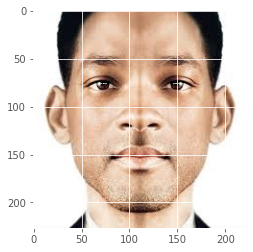

In [38]:
images_withoutMask = os.listdir("./New Masks Dataset/Train/Non Mask")
sample_img_withoutMask = random.choice(images_withoutMask)
image = load_img("./New Masks Dataset/Train/Non Mask/"+sample_img_withoutMask)
plt.imshow(image)

## Data Augmentation

In [39]:
img_width=224
img_height=224

# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 50
BS = 32
train_data_dir="./New Masks Dataset/Train"
test_data_dir="./New Masks Dataset/Validation"

all_train_imagePaths = list(paths.list_images(train_data_dir))
all_test_imagePaths = list(paths.list_images(test_data_dir))
train_data = []
train_labels = []
test_data = []
test_labels = []

In [40]:
# loop over the image paths
for imagePath in all_train_imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath,color_mode='rgb', target_size=(224, 224),interpolation='bicubic')
	image = img_to_array(image)
	image = preprocess_input(image)
    

	# update the data and labels lists, respectively
	train_data.append(image)
	train_labels.append(label)

In [41]:
# loop over the image paths
for imagePath in all_test_imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath,color_mode='rgb', target_size=(224, 224),interpolation='bicubic')

	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	test_data.append(image)
	test_labels.append(label)

In [42]:
def convert_data_labels(data,labels):
    # convert the data and labels to NumPy arrays
    data = np.array(data, dtype="float32")
    labels = np.array(labels)

    # perform one-hot encoding on the labels
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    labels = to_categorical(labels)
    return  data,labels

In [43]:
train_data,train_labels = convert_data_labels(train_data,train_labels)
test_data,test_labels = convert_data_labels(test_data,test_labels)

In [44]:
print("==================================")
print("Size of train dataset : ",train_data.shape[0])
print("==================================")
print("Size of test dataset : ",test_data.shape[0])
print("==================================")

Size of train dataset :  600
Size of test dataset :  306


In [45]:
# train datagen
train_datagen = ImageDataGenerator(
                  rotation_range=60,
                  zoom_range=[0.4,1.0],
                  width_shift_range=0.3,
                  height_shift_range=0.3,
                  shear_range=0.15,
                  horizontal_flip=True,
                  #vertical_flip=True, because in real life you wouldn't see a face upside down. putting this might hurt the overall preformance
#                   brightness_range=[0.001,0.005], # very unstable and images became unreadable with it
                  fill_mode="nearest")

train_generator = train_datagen.flow(train_data, train_labels, batch_size=BS)

## Showing a sample with augmentation on

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'Without Mask')

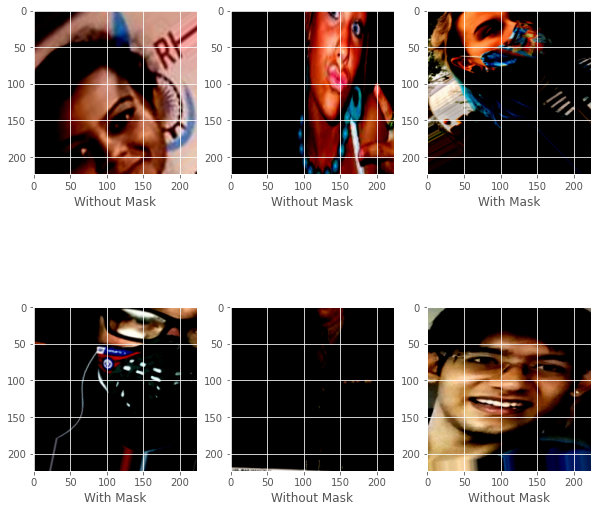

In [46]:
# Get some random images
x,Y = train_datagen.flow(train_data, train_labels, batch_size=BS).next()
y=[]

# Transfer y label from float to text
for i in range(6):
    if str(Y[i,0])=="1.0":
        y.append("With Mask")
    else:
        y.append("Without Mask")
        
        
# Show random samples with augmentation on
f, axarr = plt.subplots(2,3,figsize=(10,10))
axarr[0,0].imshow(x[0])
axarr[0,0].set_xlabel(y[0])

axarr[0,1].imshow(x[1])
axarr[0,1].set_xlabel(y[1])

axarr[0,2].imshow(x[2])
axarr[0,2].set_xlabel(y[2])

axarr[1,0].imshow(x[3])
axarr[1,0].set_xlabel(y[3])

axarr[1,1].imshow(x[4])
axarr[1,1].set_xlabel(y[4])

axarr[1,2].imshow(x[5])
axarr[1,2].set_xlabel(y[5])

# for i in range(0,3):
#     image = x[i]
#     imshow(image)

# #  Model Building

### Loading EfficientNet model

In [47]:
# we can load a better model if we had better resources

# efficientnet = EfficientNetB3(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

### Load MobileNetV2

In [48]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [49]:
def construct_model(m):
    # construct the head of the model that will be placed on top of the the base model
    headModel = m.output
    headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(2, activation="softmax")(headModel)
    # place the head FC model on top of the base model (this will become the actual model we will train)
    model = Model(inputs=m.input, outputs=headModel)
    return model

In [50]:
model = construct_model(mobilenet)

In [51]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
print("Done !!")

[INFO] compiling model...
Done !!


In [52]:
# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in mobilenet.layers:
	layer.trainable = False

In [53]:
# this code is to show how much time required to train the model using different algorithms
from datetime import datetime
def timer(start_time= None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        print('\n Time taken: %i hours %i minutes and %s seconds. '% (thour,tmin,round(tsec,2)))

### Callback Function 

In [54]:
import tensorflow as tf
# checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
# # history=model.fit(train_data,train_target,epochs=100,callbacks=[checkpoint],validation_split=0.2)
# EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True)

# ModelCheckPoint
checkPoint = keras.callbacks.ModelCheckpoint(filepath="/content/sample_data/fmd_model.h5",
                             monitor='val_loss',
                             mode='auto',
                             save_best_only=True,
                             verbose=1)

# ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

TBoard = tf.keras.callbacks.TensorBoard(log_dir='./logs')
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir='./logs', histogram_freq=1)

In [55]:
callbacks = [earlystop , checkPoint, learning_rate_reduction, TBoard]

## Model Fitting 

In [56]:
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
#%tensorboard --logdir {logs_base_dir
#%load_ext tensorboard.notebook
%load_ext tensorboard
%tensorboard --logdir {logs_base_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 14484), started 1:11:01 ago. (Use '!kill 14484' to kill it.)

In [57]:
start_time=timer(None)
classifier = model.fit(
    train_datagen.flow(train_data, train_labels, batch_size=BS), 
    epochs=20,
    validation_data=(test_data,test_labels),
    validation_steps=len(test_data)//BS,
    steps_per_epoch=len(train_data)//BS,
    callbacks=callbacks
)
timer(start_time)

Epoch 1/20
18/18 [==============================] - ETA: 0s - loss: 0.5612 - accuracy: 0.7465
Epoch 1: val_loss improved from inf to 0.33085, saving model to /content/sample_data\fmd_model.h5
18/18 [==============================] - 181s 8s/step - loss: 0.5612 - accuracy: 0.7465 - val_loss: 0.3308 - val_accuracy: 0.9510 - lr: 1.0000e-04
Epoch 2/20
18/18 [==============================] - ETA: 0s - loss: 0.2642 - accuracy: 0.9208
Epoch 2: val_loss improved from 0.33085 to 0.14664, saving model to /content/sample_data\fmd_model.h5
18/18 [==============================] - 117s 6s/step - loss: 0.2642 - accuracy: 0.9208 - val_loss: 0.1466 - val_accuracy: 0.9641 - lr: 1.0000e-04
Epoch 3/20
18/18 [==============================] - ETA: 0s - loss: 0.1517 - accuracy: 0.9419
Epoch 3: val_loss improved from 0.14664 to 0.10044, saving model to /content/sample_data\fmd_model.h5
18/18 [==============================] - 113s 6s/step - loss: 0.1517 - accuracy: 0.9419 - val_loss: 0.1004 - val_accuracy:

## Training Loss and Accuracy Visualization 

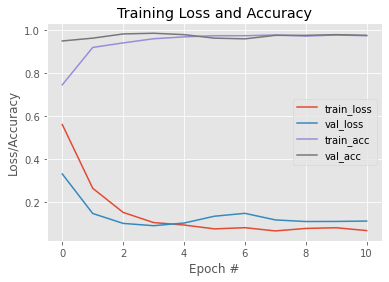

In [58]:
# plot the training loss and accuracy
plt.style.use("ggplot")
N = 10 # epochs number
plt.figure()
plt.plot( classifier.history["loss"], label="train_loss")
plt.plot( classifier.history["val_loss"], label="val_loss")
plt.plot( classifier.history["accuracy"], label="train_acc")
plt.plot( classifier.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model")

### Find Prediction

In [59]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(test_data, batch_size=BS)

[INFO] evaluating network...


In [60]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
y_pred = predIdxs
predIdxs = np.argmax(predIdxs, axis=1)

### Print some Test results

In [61]:
y_pr = []

for y in y_pred:
    if y[0]>y[1]:
        y_pr.append(1)
    else:
        y_pr.append(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'Prediction: 1\nGround Truth: 1.0')

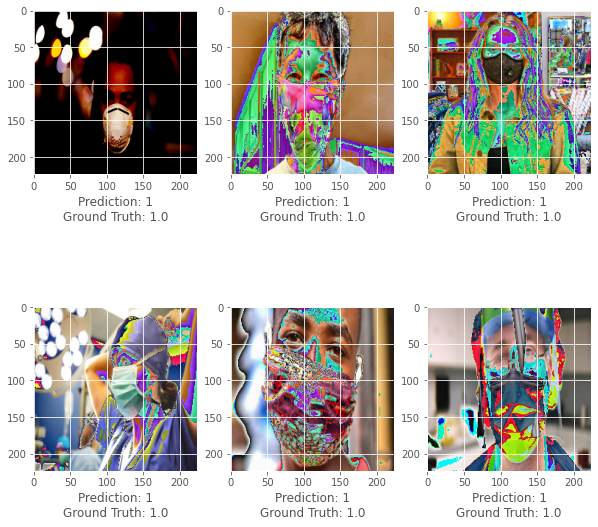

In [76]:
# Get some random images
x,y = test_data,test_labels#.next()
# y=[]

# # Transfer y label from float to text
# for i in range(6):
#     if str(Y[i])=="1.0":
#         y.append("With Mask")
#     else:
#         y.append("Without Mask")
        
        
# Show random samples with augmentation on
f, axarr = plt.subplots(2,3,figsize=(10,10))

axarr[0,0].imshow(x[0])
axarr[0,0].set_xlabel("Prediction: "+str(y_pr[0])+"\nGround Truth: "+str(y[0,0]))

axarr[0,1].imshow((x[1] * 255).astype(np.uint8))
axarr[0,1].set_xlabel("Prediction: "+str(y_pr[1])+"\nGround Truth: "+str(y[1,0]))

axarr[0,2].imshow((x[2] * 255).astype(np.uint8))
axarr[0,2].set_xlabel("Prediction: "+str(y_pr[2])+"\nGround Truth: "+str(y[2,0]))

axarr[1,0].imshow((x[3] * 255).astype(np.uint8))
axarr[1,0].set_xlabel("Prediction: "+str(y_pr[3])+"\nGround Truth: "+str(y[3,0]))

axarr[1,1].imshow((x[4] * 255).astype(np.uint8))
axarr[1,1].set_xlabel("Prediction: "+str(y_pr[4])+"\nGround Truth: "+str(y[4,0]))

axarr[1,2].imshow((x[5] * 255).astype(np.uint8))
axarr[1,2].set_xlabel("Prediction: "+str(y_pr[5])+"\nGround Truth: "+str(y[5,0]))

# for i in range(0,3):
#     image = x[i]
#     imshow(image)

### Find Accuracy

In [63]:
# check accuracy
val_loss,val_acc = model.evaluate(test_data,test_labels)
print("=======================================================")
print("Accuracy is : ",val_acc)
print("=======================================================")
print("Loss is : ",val_loss)
print("=======================================================")

10/10 [==============================] - 21s 803ms/step - loss: 0.0897 - accuracy: 0.9869
Accuracy is :  0.9869281053543091
Loss is :  0.08970407396554947


### Classification Report

In [64]:
test_lab = []

for y in test_labels:
    if y[0]>y[1]:
        test_lab.append(1)
    else:
        test_lab.append(0)

In [65]:
# show a nicely formatted classification report
print(classification_report(test_lab, y_pr)) #test_labels.argmax(axis=1)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       153
           1       0.99      0.99      0.99       153

    accuracy                           0.99       306
   macro avg       0.99      0.99      0.99       306
weighted avg       0.99      0.99      0.99       306



In [66]:
# plot_confusion_matrix(classifier, test_lab, y_pr)


# # Saving plot to output file


# plt.title("Naive Bayes Confusion Matrix",pad=40,fontweight="bold")
# plt.savefig("NaiveBayes-ConfusionMatrix.pdf")
# os.chdir("..")


# plt.show() 

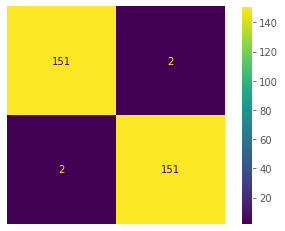

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(test_lab, y_pr)
display_labels= np.asarray([0,1])
include_values = True
cmap='viridis'
ax=None
colorbar=True
    
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp = disp.plot(include_values=include_values,
                 cmap=cmap, ax=ax) #, xticks_rotation=xticks_rotation
plt.axis('off')
plt.show()